# Humor Scoring Using BERT

In this notebook, we will train BERT to score input sentences as humorous or non-humorous. It will be trained on the modified headlines dataset.


In [1]:
#mount google drive

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Part 1: Preprocessing

Process the input so that it's ready for the training process

In [2]:
### dependencies...

#install bert dependency: transformer library
!pip install transformers
#import transformers

     |████████████████████████████████| 1.5MB 12.5MB/s 
     |████████████████████████████████| 2.9MB 49.2MB/s 
     |████████████████████████████████| 890kB 59.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b1a60559b1e24ccccd60353eebd66c2fc538a04653503f83cdd0c6742cd1150e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# check the google drive path
!ls 'gdrive/MyDrive/humor_generation/helpers'


bert_fns.py  prep_humor_data.py


In [4]:
# more dependencies...
import sys
if 'gdrive/MyDrive/humor_generation/helpers' not in sys.path:
  sys.path.append('gdrive/MyDrive/humor_generation/helpers')
print(sys.path)
%run 'gdrive/MyDrive/humor_generation/helpers/prep_humor_data.py'
%run 'gdrive/MyDrive/humor_generation/helpers/bert_fns.py'

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', 'gdrive/MyDrive/humor_generation/helpers']


In [5]:
#preprocess the data... (use inbuilt function)
fpath1 = 'gdrive/MyDrive/humor_generation/datasets/bert_training/train.csv'
# make a path for the humorous statements that I made.
fpath2 = 'gdrive/MyDrive/humor_generation/datasets/bert_training/train_funlines.csv'
d1, funny, not_funny = preprocess_data(fpath1)
d2, f2, nf2 = preprocess_data(fpath2)
data = d1 + d2
funny += f2
not_funny += nf2

#change data format & create train / test sets.
print("total number of funny instances: " + str(funny))
print("total number of non funny instances: " + str(not_funny))

#[handle augmented data here]
create_aug_data = False

9652
8248
total number of funny instances: 10822
total number of non funny instances: 7078


In [6]:
#Start with BERT-specific prepping... tokenize input & get attn mask.
sentences = [d[0] for d in data]
labels = [d[1] for d in data]
print(sentences[0])
print(labels[0])

#use pre-written fn to tokenize the sentences and create attn mask.
input_ids, attn_mask = tokenize_inputs_attn_mask(sentences)
print("attention mask: {}".format(attn_mask[0]))


#handle augmented data separately
if create_aug_data:
  print("preprocessing augmented data...")
  a_sentences = [d[0] for d in aug_data]
  a_labels = [d[1] for d in aug_data]
  a_input_ids, a_attn_mask = tokenize_inputs_attn_mask(a_sentences)

France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
0
Loading BERT tokenizer...



 Original:  France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Tokenized:  ['france', 'is', '‘', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', 'twins', '’', 'without', 'trial', 'in', 'iraq']
Token IDs:  [2605, 2003, 1520, 5933, 2091, 2049, 4480, 2040, 2587, 8178, 1521, 2302, 3979, 1999, 5712]
Original:  France is ‘ hunting down its citizens who joined twins ’ without trial in Iraq
Token IDs: [101, 2605, 2003, 1520, 5933, 2091, 2049, 4480, 2040, 2587, 8178, 1521, 2302, 3979, 1999, 5712, 102]

Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0

Done.
[ 101 2605 2003 1520 5933 2091 2049 4480 2040 2587 8178 1521 2302 3979
 1999 5712  102    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [7]:
### split data into training and test datasets, convert to torch tensors...
import torch
import numpy as np

#let's try test_pct = 0.1, 0.3, 0.5, 0.7, 0.8, 0.9
TEST_PCT = 0.1
outputs = tr_val_split(input_ids, labels, attn_mask, test_ratio = TEST_PCT)
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = outputs

#add augmented data to trdata ONLY
if create_aug_data:
  AUG_PCT = 0.05 #the rest will be converted to trdata...
  a_outputs = tr_val_split(a_input_ids, a_labels, a_attn_mask, test_ratio = AUG_PCT)
  a_train_inputs, _, a_train_labels, _, a_train_masks, _ = a_outputs
  train_inputs = torch.cat([train_inputs, a_train_inputs], dim=0)
  train_labels = torch.cat([train_labels, a_train_labels], dim=0)
  train_masks = torch.cat([train_masks, a_train_masks], dim=0)
  outputs = (train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks)

#create train & validation iterators
batch_size=32
train_dataloader, validation_dataloader = create_data_iterators(*outputs, batch_size)

In [8]:
## print out the size of the training data...
print("training dataloader length: {}".format(len(train_dataloader)))
print("validation dataloader length:   {}".format(len(validation_dataloader)))

## doublecheck
print("train inputs size: {}".format(len(train_inputs)))
print("validation inputs size: {}".format(len(validation_inputs)))

training dataloader length: 504
validation dataloader length:   56
train inputs size: 16110
validation inputs size: 1790


## Training

Now, we actually start using BERT. We create the Bert model (from a pretrained model that we import) and apply it to the dataset.

In [9]:
## specify hardware.
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [10]:
### RERUN THIS TOO: otherwise the model will remember the old trdata!
'''
  Create the BERT model.
  We will here import a pretrained bert model that has already been optimized for sequence classification.
'''

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
#### RERUN (when changing trdata size)
from transformers import get_linear_schedule_with_warmup, AdamW

## specify the optimizer

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## more model specs: specify the weight decay schedule.
# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


'''
  next step: specify some accuracy functions.
'''
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [12]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


#########
# DEBUG
#########
epochs = 2


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
# during validation, store output logits, labels & tokens so we can reconstruct errors.
out_logits = []
out_labels = []
in_tokens = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for step, batch in enumerate(validation_dataloader):

        ### if even this doesn't work, I'm going to start calling a separte function in here to thoroughly debug.
        # Progress update every 40 batches (need to make sure the batches are correct...)
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)        
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(validation_dataloader), elapsed))

        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        #[DEBUG] what are the output shapes?
        #print("[debug] input_ids shape: ", b_input_ids.shape)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        ### [DEBUG]
        #print("[debug] output logit shape:", logits.shape)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

        #save the inputs, logit results, and labels for analysis...
        if (epoch_i + 1) == epochs:
            out_logits.append(logits)
            out_labels.append(label_ids)
            in_tokens.append(b_input_ids)

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    504.    Elapsed: 0:00:11.
  Batch    80  of    504.    Elapsed: 0:00:22.
  Batch   120  of    504.    Elapsed: 0:00:34.
  Batch   160  of    504.    Elapsed: 0:00:45.
  Batch   200  of    504.    Elapsed: 0:00:56.
  Batch   240  of    504.    Elapsed: 0:01:08.
  Batch   280  of    504.    Elapsed: 0:01:19.
  Batch   320  of    504.    Elapsed: 0:01:31.
  Batch   360  of    504.    Elapsed: 0:01:43.
  Batch   400  of    504.    Elapsed: 0:01:54.
  Batch   440  of    504.    Elapsed: 0:02:06.
  Batch   480  of    504.    Elapsed: 0:02:19.

  Average training loss: 0.65
  Training epcoh took: 0:02:26

Running Validation...
  Accuracy: 0.66
  Validation took: 0:00:05

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    504.    Elapsed: 0:00:12.
  Batch    80  of    504.    Elapsed: 0:00:24.
  Batch   120  of    504.    Elapsed: 0:00:36.
  Batch   160  of    504.    Elapsed: 0:00:48.
  Batch   200  of    504.    Elap

In [13]:
### here, let's take the validation data we saved and try to analyze it more.
preds = out_logits[0]
pred_flat = np.argmax(preds, axis=1).flatten()
print(preds)
print(pred_flat)

# Q: how can we convert these into probabilities? Maybe divide by the max value out of (p_1 and p_0)?
#  >> the real answer: apply the logistic function to P(1)

[[-0.7716808   0.9887316 ]
 [ 0.01280305 -0.4718779 ]
 [-0.83237684  0.6538481 ]
 [-1.0247082   0.8997653 ]
 [-1.2322806   1.4947053 ]
 [-0.7150711   0.6086088 ]
 [-1.3890189   1.5529889 ]
 [ 0.3667687  -0.6053739 ]
 [-0.7295981   0.71150964]
 [-0.5343836   0.4676876 ]
 [-0.07085785 -0.21385741]
 [ 0.17543204 -0.35678414]
 [ 0.3066181  -0.68033576]
 [-0.16589732 -0.11649675]
 [-0.0424276  -0.2727683 ]
 [ 0.28689364 -0.3251935 ]
 [ 0.04426246 -0.2278276 ]
 [-0.73401254  0.44084877]
 [-0.29607287  0.14184856]
 [-0.5689494   0.24242856]
 [-1.1591725   1.2012486 ]
 [-1.176376    1.3645107 ]
 [-1.4069732   1.7613201 ]
 [-0.6248842   0.57534236]
 [ 0.21435316 -0.4745075 ]
 [ 0.178344   -0.403751  ]
 [-1.2056179   1.3040327 ]
 [ 0.07745255 -0.2429566 ]
 [-0.17310797 -0.04243121]
 [-1.0015625   0.9825573 ]
 [-0.19089189 -0.07894316]
 [-0.4505476   0.16781016]]
[1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1]


##Analysis of Generated Humor

Using the BERT instance trained above, analyze the humor levels in the generated sentences.

In [ ]:
'''
================ TODO NEXT ========================

get results from our pipeline, package them up to be sent to BERT, and then analyze them.
  * Analyze the raw probabilities.

~ might be nice to save this trained bert model? ## [Just forget this, it doesn't want to save the final classification layer :(]

'''

'''
#skip this cell, it's not working.

# how to make this work: you have to use the same "from_pretrained" initializer as in the function above. (with n_classes parameter=2)
# problem: If you used that function, I don't think the classifier would be trained!

# # step 1: save the pretrained model
# model.save_pretrained('gdrive/MyDrive/humor_generation/models/bert_humor_classifier')

#step 2: extract pretrained model from directory. [haven't tested this yet]
from transformers import BertConfig, BertModel

config1 = BertConfig.from_json_file('gdrive/MyDrive/humor_generation/models/bert_humor_classifier/config.json')
saved_model = BertModel.from_pretrained('gdrive/MyDrive/humor_generation/models/bert_humor_classifier/pytorch_model.bin', config= config1)
'''




In [ ]:
# next: we need to tokenize, batch, create attention masks, and input into the model.
# more dependencies...
import sys
if 'gdrive/MyDrive/humor_generation/helpers' not in sys.path:
  sys.path.append('gdrive/MyDrive/humor_generation/helpers')
  print(sys.path)
  %run 'gdrive/MyDrive/humor_generation/helpers/prep_humor_data.py'
  %run 'gdrive/MyDrive/humor_generation/helpers/bert_fns.py'

In [ ]:
# open the proper file and extract / preprocess the training data
import csv
fpath1 = 'gdrive/MyDrive/humor_generation/cbow_news/in_process_data/altered_preds_step1.csv'

sent_ids = []
aug_output = []
with open(fpath1) as fpreds:
  jokereader = csv.reader(fpreds)
  next(jokereader)  # skip the header.
  for row in jokereader:
    sent = row[1]
    aug_output.append(sent)
    id = row[0]
    sent_ids.append(id)
  
print(aug_output[:5])

# next, send this to the bert preprocessor.
# tokenize sentences and create attn masks
input_ids, attn_mask = tokenize_inputs_attn_mask(aug_output)

['thousands of gay and bisexual men convicted of long abolished sexual senate are posthumously pardoned', 'thousands of gay and bisexual men convicted of long abolished sexual americans are posthumously pardoned', 'spanish police detain trump and search ripoll addresses in hunt for terror suspects', 'special prosecutor appointed to report', 'n y times reprimands trump for sharing unfounded rumor about melania trump']
Loading BERT tokenizer...
 Original:  thousands of gay and bisexual men convicted of long abolished sexual senate are posthumously pardoned
Tokenized:  ['thousands', 'of', 'gay', 'and', 'bisexual', 'men', 'convicted', 'of', 'long', 'abolished', 'sexual', 'senate', 'are', 'posthumously', 'pardon', '##ed']
Token IDs:  [5190, 1997, 5637, 1998, 22437, 2273, 7979, 1997, 2146, 8961, 4424, 4001, 2024, 12770, 14933, 2098]
Original:  thousands of gay and bisexual men convicted of long abolished sexual senate are posthumously pardoned
Token IDs: [101, 5190, 1997, 5637, 1998, 22437, 

In [ ]:
# after the BERT tokenizer, create the tensor dataset & dataloader?

import numpy as np

# I think you can just convert the current data into numpy arrays, then into torch tensors.
validation_inputs = np.array(input_ids).astype(int)
validation_inputs = torch.tensor(validation_inputs)
validation_masks = torch.tensor(attn_mask)

#let's try plugging this into the model.

'''
outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask)
'''


'\noutputs = model(b_input_ids, \n                token_type_ids=None, \n                attention_mask=b_input_mask)\n'

In [ ]:
# SKIP THIS CELL - it also eats up too much memory.

#sample: just try to get this working on one example.

print(len(aug_output))
print(validation_inputs.shape)
print(validation_masks.shape)

#print out the first of each?
print(aug_output[0])
print(validation_inputs[0]) #lengths are slightly different, if we're really concerned we can investigate bert tokenizer.

#run the model on just one...
print("\nrunning bert...")
op = model(validation_inputs[0].unsqueeze(0).to(device), token_type_ids=None, attention_mask=validation_masks[0].unsqueeze(0).to(device))
print(op[0].shape)

print("\n")
print(op[0])

'''
# outputs = model(b_input_ids, 
#                token_type_ids=None, 
#                attention_mask=b_input_mask)
'''

34209
torch.Size([34209, 50])
torch.Size([34209, 50])
thousands of gay and bisexual men convicted of long abolished sexual senate are posthumously pardoned
tensor([  101,  5190,  1997,  5637,  1998, 22437,  2273,  7979,  1997,  2146,
         8961,  4424,  4001,  2024, 12770, 14933,  2098,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

running bert...
torch.Size([1, 2])


tensor([[-0.7204,  0.1327]], device='cuda:0', grad_fn=<AddmmBackward>)


'\n# outputs = model(b_input_ids, \n#                token_type_ids=None, \n#                attention_mask=b_input_mask)\n'

In [ ]:
# create a tensor dataset and run the below.

#requires the function, "create_data_iterators". This is a very simple function, do it tmrw.

def create_data_itr(validation_inputs, validation_masks, batch_size=32):
  validation_data = TensorDataset(validation_inputs, validation_masks)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
  return validation_dataloader
    

batch_size=32
test_dataloader = create_data_itr(validation_inputs, validation_masks, batch_size)

In [ ]:
# generate scores for validation.

out_logits = []
in_tokens = []

for step, batch in enumerate(test_dataloader):

        # Progress update every 40 batches (need to make sure the batches are correct...)
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)        
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch

        #[DEBUG] what are the output shapes?
        # print("[debug] input_ids shape: ", b_input_ids.shape)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        ### [DEBUG]
        # print("[debug] output logit shape:", logits.shape)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        
        # Track the number of batches
        nb_eval_steps += 1

        #save the inputs, logit results, and labels for analysis...
        if (epoch_i + 1) == epochs:
            out_logits.append(logits)
            in_tokens.append(b_input_ids)

    # Report the final accuracy for this validation run.
    #print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("\n output logits:")
print(out_logits[:10])



 output logits:
[array([[-0.10259536, -0.0302136 ],
       [ 0.26917467, -0.3265173 ],
       [-0.45545426,  0.8180601 ],
       [ 0.5370537 , -0.24718463],
       [-0.5410654 ,  0.6365072 ],
       [-0.16520555,  0.51062095],
       [ 0.24478681,  0.20929036],
       [ 0.5888642 , -0.29840088],
       [ 0.38325027, -0.01231874],
       [ 0.784606  , -0.47141433],
       [ 0.7479833 , -0.4496566 ],
       [ 0.5498434 , -0.29440725],
       [ 0.5148533 , -0.26997465],
       [ 0.5207918 , -0.22197433],
       [-0.06434891,  0.20570123],
       [-0.18165816,  0.3894839 ],
       [ 0.00464029,  0.44292805],
       [ 0.31987017,  0.08765332],
       [ 0.70630366, -0.5098017 ],
       [ 0.32669526, -0.2177981 ],
       [-0.0561959 ,  0.08650753],
       [ 0.3375068 , -0.21853232],
       [-0.01580168,  0.16879542],
       [ 0.34226826, -0.16985291],
       [ 0.3460017 , -0.19717465],
       [ 0.4170067 , -0.2123852 ],
       [ 0.18163233, -0.03807513],
       [ 0.21730761,  0.06771749],
  

In [ ]:
#next step: save the evaluation results

#before we save the output, we want to combine all the arrays into a single "1070 x 2" array.
out_logits_ccat = np.vstack(out_logits)
print(out_logits_ccat.shape)

#print out the input sentence, as well as the two entries of the logit array.
import csv

fpath = 'gdrive/MyDrive/humor_generation/cbow_news/in_process_data/evaluation_2.csv'
with open(fpath, 'w') as fout:
  jokewriter = csv.writer(fout)
  jokewriter.writerow(["id", "sentence", "not_funny_logit", "funny_logit"])
  for i in range(len(aug_output)):
    id = sent_ids[i]
    s = aug_output[i]
    l = out_logits_ccat[i]
    row = [id, s, l[0], l[1]]
    print(row)
    jokewriter.writerow(row)


Text(0.5, 1.0, 'Output humor scores from BERT (Human Data)')

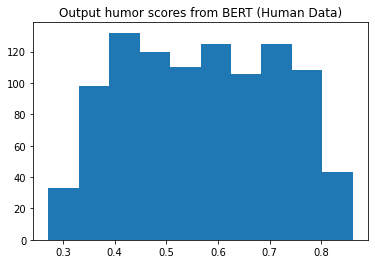

In [17]:
# we also want to analyze the results.

import matplotlib.pyplot as plt
from scipy.special import expit



#first, apply a sigmoid to the "funny" score.
# x = expit(out_logits_ccat[:1000, 1])


#out_logits_ccat = np.vstack(out_logits)
#print(out_logits_ccat.shape)
x = expit(out_logits_ccat[:1000, 1])

plt.hist(x=x)
plt.title("Output humor scores from BERT (Human Data)")

# then, create a histogram showing frequency of funny and non-funny results.


# this would be good to compare with a histogram of the funny results in the other dataest.

In [ ]:
# output the mean score & standard dev?
print("mean:", np.mean(x))
print("standard dev:", np.std(x))


mean: 0.49587628
standard dev: 0.1134721


## Results:

With different training data sizes:
1. using 90% of the data for training: accuracy=0.68
2. using 70% of the data: accuracy=0.66
  - the confusion matrix is almost exactly the same as #3
  - Check that the confusion matrix becomes more regular after 4 epochs?

3. using 50% of the data: accuracy=0.65

4. use 30% of the data: accuracy=0.65
  - So the problem is that it doesn't seem to be learning very much from additional data...

- also trying 20%...
  - that gives around 60% accuracy
  - although it has a very high pct of false pos (74%).

5. use 10% fo the dataset (2)
  - it's getting 53% accuracy... so it's barely learning anything.

maybe check the F1 scores or something? Maybe it's classifying everything as funny or not funny.

In [ ]:
#pickle results
import pickle as pkl

with open('./drive/My Drive/Colab Notebooks/py_files_humor/val_preds_20pcttr.pkl', 'wb') as f:
  output = [in_tokens, out_labels, out_logits]
  pkl.dump(output, f)


In [ ]:
#unpickle results
import pickle as pkl

#this is the result wiht 50% of the training data being used to train the model.
with open('./drive/My Drive/Colab Notebooks/py_files_humor/val_preds_70pcttr.pkl', 'rb') as f:
  in_tokens, out_labels, out_logits = pkl.load(f)

print(in_tokens[0])
print(out_labels[0])
print(out_logits[0])


tensor([[  101, 24166, 13196,  ...,     0,     0,     0],
        [  101, 12642, 11052,  ...,     0,     0,     0],
        [  101, 19044,  2708,  ...,     0,     0,     0],
        ...,
        [  101,  6031,  1998,  ...,     0,     0,     0],
        [  101, 23853,  4275,  ...,     0,     0,     0],
        [  101, 16360,  1012,  ...,     0,     0,     0]], device='cuda:0')
[0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0]
[[-0.91462606  0.40076062]
 [-0.15726662 -0.17962816]
 [-0.5539107   0.22284134]
 [-0.37560263  0.12036578]
 [-1.1982032   0.5113771 ]
 [-0.368609    0.01179522]
 [-1.204415    0.51296073]
 [ 0.41470796 -0.36190483]
 [-1.0032601   0.5223802 ]
 [-0.33061895  0.15841323]
 [-0.7320643   0.31218117]
 [-0.31531614 -0.16121048]
 [ 0.11153173 -0.22641303]
 [-0.16293725 -0.07103235]
 [-0.10180017 -0.24721903]
 [ 0.38158387 -0.28379595]
 [-0.02476895 -0.19750805]
 [-0.46595985  0.12077504]
 [-0.46786484  0.25975907]
 [-0.18190677  0.03193663]
 [-1.1743947   

In [ ]:
#repackage data into the proper format
from transformers import BertTokenizer
import numpy as np

#retokenize the sentence ids...
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentences = []
for batch in in_tokens:
  np_batch = batch.cpu().numpy()
  for ids in np_batch:
    tokens = tokenizer.convert_ids_to_tokens(ids)
    sentences.append(tokens)

#flatten out the logits
preds_list = []
for preds in out_logits:
  pred_flat = np.argmax(preds, axis=1).flatten()
  preds_list.append(pred_flat)
preds_flattened = np.concatenate(preds_list)

#flatten labels
labels_flattened = np.concatenate(out_labels)

print(sentences[0])
print(preds_flattened)
print(labels_flattened)


Loading BERT tokenizer...
['[CLS]', 'stormy', 'daniels', "'", 'lawyer', 'says', 'porn', 'star', 'was', 'physically', 'threatened', 'to', 'remain', 'silent', 'over', 'alleged', 'movie', 'with', 'trump', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1 0 1 ... 0 1 1]
[0 0 1 ... 1 1 0]


In [ ]:
print(preds_flattened.shape)
print(labels_flattened.shape)

(5370,)
(5370,)


[[ 859 1286]
 [ 573 2652]]
tn: 859, fp: 1286, fn: 573, tp: 2652


Text(0.5, 1, 'Confusion Matrix')

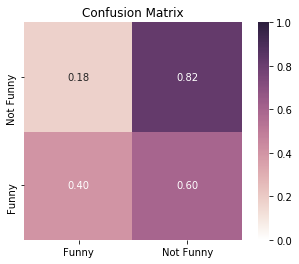

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

cm = confusion_matrix(labels_flattened, preds_flattened)
print(cm)

tn, fp, fn, tp = cm.ravel()
print("tn: {}, fp: {}, fn: {}, tp: {}".format(tn, fp, fn, tp))


### here, create a nice chart.
cm_ratio = np.vstack([cm[0]/cm[0].sum(), cm[1]/cm[1].sum()])
df_cm = pd.DataFrame(cm_ratio, 
  index = [ 'Funny', 'Not Funny'],
  columns = ['Funny', 'Not Funny'])
fig = plt.figure()
plt.clf()

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=1.0, fmt='.2f', cmap=cmap)

res.invert_yaxis()

plt.title('Confusion Matrix')


## I don't think this is too bad, although we can always try doing f1 scores or something...


In [ ]:
#next step: need to check on what's actually causing the lack of learning...

#most of the errors, as we notice, aree false negatives. It thinks something's not funny, but it is...
## we can also try running more epochs to see if that helps...

#first, let's look at misclassified funny examples.
'''
sentences = np.array(sentences)
print(sentences.shape)
'''

print(sentences[:5])

#false positive: label= 0 and pred= 1...
print("total false positives: ")
l = len(labels_flattened)
fpos = [i for i in range(l) if (labels_flattened[i]==0 and preds_flattened[i]==1)]
print(len(fpos))

#let's isolate the set of false positives...
fp_sent = sentences[fpos]
print(fp_sent[:5])
# count the common tokens?

#preds_flattened

[['[CLS]' 'stormy' 'daniels' "'" 'lawyer' 'says' 'porn' 'star' 'was'
  'physically' 'threatened' 'to' 'remain' 'silent' 'over' 'alleged'
  'movie' 'with' 'trump' '[SEP]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]']
 ['[CLS]' 'storms' 'moist' '##en' 'at' 'least' '78' 'in' 'western' 'and'
  'northern' 'india' '[SEP]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '[PAD]']
 ['[CLS]' 'epa' 'chief' 'scott' 'pr' '##uit' '##t' ':' 'two' 'top' 'aide'
  '##s' 'depart' 'amid' 'psychic' 'investigations' '[SEP]' '[PAD]'
  '[PAD]' '[PAD]' '[PAD]' '[PAD]' '

In [ ]:
## sort the dict by the most common tokens - returns list of tuples.
def remove_unhelpful_tokens(tok_dict):
  unhelpful_tokens = ['[PAD]', '[CLS]', '[SEP]', "'", 'to', 's', ',', 'the', '##s', 'in', '’', '.', ':', 'of', 'for', 'a', '-', 'on', 'is', 'and', 'with', '‘', 't', 'says', 'at', 'n', 'as', 'after', 'it', 'from', 'new', 'he', 'us', 'about', '"', 'his', '?', 'go', 'u', 'not', 'will', 'by', 'no', 'has', 'was', '##p', 'are', '##ea']
  for t in unhelpful_tokens:
    _ = tok_dict.pop(t, None)
  return tok_dict

def sort_tokens(tokens):
  common_tokens = [(k, v) for k, v in sorted(tokens.items(), key=lambda item: item[1], reverse=True)]
  return common_tokens

def scale_counts(tokens, sentences):
  l = sentences.shape[0] + 0.0
  for k in tokens.keys():
    tokens[k] *= 1000/l
  return tokens

## find the most common tokens in sentences array
def tokenize_sentences(sentences):
  tokens = {}
  for sent in sentences:
    for w in sent:
      ct = tokens.get(w)
      if ct is not None:
        tokens[w] += 1.0
      else:
        tokens[w] = 1.0
  tokens = remove_unhelpful_tokens(tokens)
  tokens = scale_counts(tokens, sentences)
  return tokens, sort_tokens(tokens)

## let's isolite non-false-positives
l = len(labels_flattened)
nfpos = set(range(l)).difference(set(fpos))
nfpos = list(nfpos)
fp_sent = sentences[fpos]
nonfp_sent = sentences[nfpos]

#print the most common tokens in both fpos & non-fpos
fp_tokens, sorted_fp_tokens = tokenize_sentences(fp_sent)
nonfp_tokens, sorted_nfp_tokens = tokenize_sentences(nonfp_sent)

print("false positive tokens: ")
print(sorted_fp_tokens[:50])
print("non false positive tokens: ")
print(sorted_nfp_tokens[:50])

### the current printed result is pretty clear - the negative entities tend to be slightly overrepresented.


false positive tokens: 
[('trump', 353.81026438569205), ('house', 53.654743390357694), ('over', 50.5443234836703), ('donald', 44.32348367029549), ('white', 38.88024883359253), ('that', 27.993779160186627), ('imp', 27.993779160186627), ('russia', 27.216174183514774), ('korea', 27.216174183514774), ('$', 27.216174183514774), ('north', 26.438569206842924), ('up', 25.66096423017107), ('have', 24.883359253499222), ('how', 24.105754276827373), ('obama', 24.105754276827373), ('i', 24.105754276827373), ('be', 24.105754276827373), ('russian', 23.32814930015552), ('##i', 23.32814930015552), ('president', 22.55054432348367), ('##y', 22.55054432348367), ('##ing', 22.55054432348367), ('report', 21.772939346811818), ('do', 20.995334370139968), ('ban', 20.995334370139968), ('against', 20.21772939346812), ('calls', 20.21772939346812), ('##t', 19.440124416796266), ('who', 19.440124416796266), ('china', 19.440124416796266), ('get', 19.440124416796266), ('what', 18.662519440124417), ('out', 17.8849144634

In [ ]:
#todo next:
# 1. remove stop words
# 2. plot this stuff out in a graph?
# 3. make the frequencies relative.
'''
helpful_tokens = set(['trump', 'house', 'over', 'donald', 'white'])
unhelpful_tokens = [t[0] for t in sorted_fp_tokens[:53] if t[0] not in helpful_tokens]
print(unhelpful_tokens)

unhelpful_tokens = ['[PAD]', '[CLS]', '[SEP]', "'", 'to', 's', ',', 'the', '##s', 'in', '’', '.', ':', 'of', 'for', 'a', '-', 'on', 'is', 'and', 'with', '‘', 't', 'says', 'at', 'n', 'as', 'after', 'it', 'from', 'new', 'he', 'us', 'about', '"', 'his', '?', 'go', 'u', 'not', 'will', 'by', 'no', 'has', 'was', '##p', 'are', '##ea']
# we are taking out the above "unhelpful tokens"
'''


['[PAD]', '[CLS]', '[SEP]', "'", 'to', 's', ',', 'the', '##s', 'in', '’', '.', ':', 'of', 'for', 'a', '-', 'on', 'is', 'and', 'with', '‘', 't', 'says', 'at', 'n', 'as', 'after', 'it', 'from', 'new', 'he', 'us', 'about', '"', 'his', '?', 'go', 'u', 'not', 'will', 'by', 'no', 'has', 'was', '##p', 'are', '##ea']


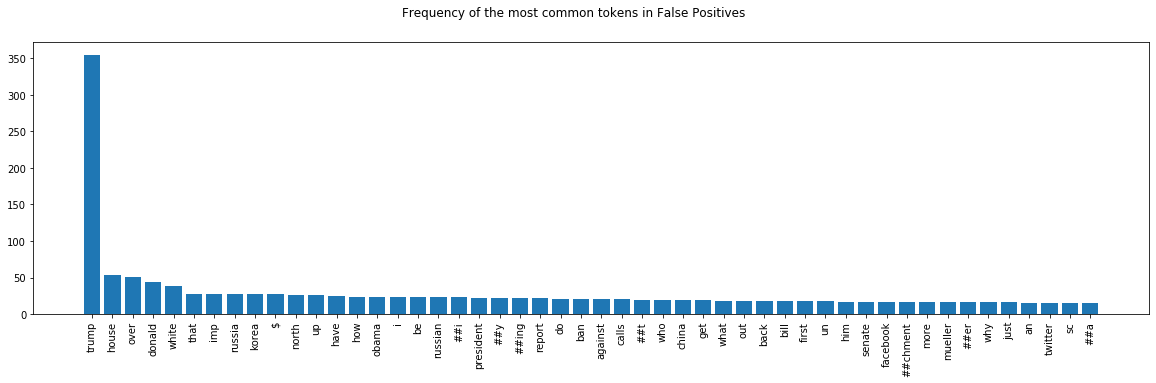

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,5))

fp_tok = sorted_fp_tokens[:50]
x = np.arange(50)
fp_ticks = [t[0] for t in fp_tok]
fp_freqs = [t[1] for t in fp_tok]

plt.suptitle('Frequency of the most common tokens in False Positives')
plt.bar(x, fp_freqs)
plt.xticks(x, fp_ticks, rotation='vertical')

'''nfp_tok = sorted_nfp_tokens[:50]
nfp_ticks = [t[0] for t in nfp_tok]
nfp_freqs = [t[1] for t in nfp_tok]

ax2.bar()
ax1.xticks(x, nfp_tok)'''

plt.show()

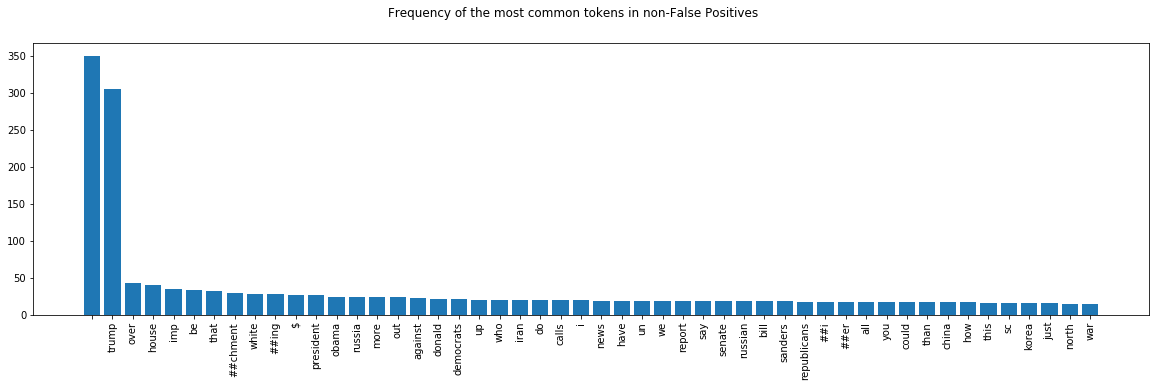

In [ ]:
## create another graph for the rest of the data (not false positives)
fig = plt.figure(figsize=(20,5))

nfp_tok = [(' ', 350.0)] + sorted_nfp_tokens[:49]
x = np.arange(50)
nfp_ticks = [t[0] for t in nfp_tok]
nfp_freqs = [t[1] for t in nfp_tok]

plt.suptitle('Frequency of the most common tokens in non-False Positives')
plt.bar(x, nfp_freqs)
plt.xticks(x, nfp_ticks, rotation='vertical')
ax.set(xlim=(0,350))

plt.show() 

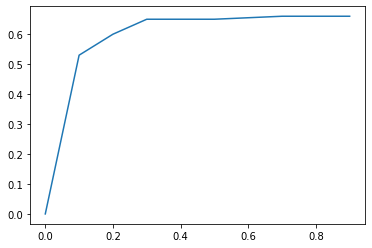

In [ ]:
import matplotlib.pyplot as plt
#graph the performance with n% training data
tr_data_pct = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
performance = [0, 0.53, 0.60, 0.65, 0.65, 0.66, 0.66]

plt.plot(tr_data_pct, performance)

## Data Augmentation Experiments

Idea: in unfunny examples, we can exchange names and places to create new unfunny examples.

In funny examples, we would have to find synonyms of words.

In [ ]:
#preprocess the data... (use inbuilt function)
fpath1 = './drive/My Drive/humor-data/train.csv'
fpath2 = './drive/My Drive/humor-data/train_funlines.csv'
d1, funny, not_funny = preprocess_data(fpath1)
d2, f2, nf2 = preprocess_data(fpath2)
data = d1 + d2
funny += f2
not_funny += nf2

#change data format & create train / test sets.
print("total number of funny instances: " + str(funny))
print("total number of non funny instances: " + str(not_funny))

9652
8248
total number of funny instances: 10822
total number of non funny instances: 7078


In [ ]:
#let's take a look at the data and how we can do this
print(type(data))
print(data[1])

<class 'list'>
['Pentagon claims 2,000 % increase in Russian trolls after bowling strikes . What does that mean ?', 1]


In [ ]:
!pip install geotext

     |████████████████████████████████| 2.0MB 2.8MB/s 


In [ ]:
from geotext import GeoText

places = GeoText("London is a great city")
print(places.cities)

places = GeoText("Russian trolls farms hacked into Facebook")
print(places.country_mentions)

['London']
OrderedDict([('RU', 1)])


In [ ]:
### let's do this in a new notebook...